# **Setup, instalación y carga de librerías**

In [1]:
COLAB = True

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
if COLAB:
    %tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import optimizers, regularizers
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model, Model

from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

import tifffile as tiff
import cv2
import pandas as pd 

import os
import zipfile
import shutil

Using TensorFlow backend.


# **Preparación de imágenes**

In [5]:
try:
    from google_drive_downloader import GoogleDriveDownloader as gdd
except:
    get_ipython().system('pip install googledrivedownloader')
    from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id="1-C8gD5A9vTqEvn_-YUVI5SkqHrIobooE",
                                                dest_path='./small_data.zip',
                                                overwrite=True,
                                                unzip=True,
                                                showsize=True)

11.4 MiB Done.
Unzipping...Done.


In [6]:
def get_file_names(path):
  return sorted([f for f in os.listdir(path)])

In [7]:
ciervos_file_names_train= get_file_names('small_data/train/Ciervos')
no_ciervos_file_names_train= get_file_names('small_data/train/No_Ciervos')

ciervos_file_names_test= get_file_names('small_data/test/Ciervos')
no_ciervos_file_names_test= get_file_names('small_data/test/No_Ciervos')

ciervos_file_names_validation= get_file_names('small_data/validation/Ciervos')
no_ciervos_file_names_validation= get_file_names('small_data/validation/No_Ciervos')

In [8]:
os.mkdir('/content/small_data_2')
os.mkdir('/content/small_data_2/train')
os.mkdir('/content/small_data_2/train/Ciervos')
os.mkdir('/content/small_data_2/train/No_Ciervos')

os.mkdir('/content/small_data_2/test')
os.mkdir('/content/small_data_2/test/Ciervos')
os.mkdir('/content/small_data_2/test/No_Ciervos')

os.mkdir('/content/small_data_2/validation')
os.mkdir('/content/small_data_2/validation/Ciervos')
os.mkdir('/content/small_data_2/validation/No_Ciervos')

In [9]:
from PIL import Image

def convert_to_png(path, file_names, output_path):

  for i in (file_names):
    image= cv2.imread(path + i, cv2.IMREAD_UNCHANGED)
    image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    formatted = (image * 255 / np.max(image)).astype('uint8')
    img = Image.fromarray(formatted)
    img.save(output_path + i[0:-4] + '.png')

In [10]:
convert_to_png('/content/small_data/train/Ciervos/', ciervos_file_names_train, '/content/small_data_2/train/Ciervos/')
convert_to_png('/content/small_data/train/No_Ciervos/', no_ciervos_file_names_train, '/content/small_data_2/train/No_Ciervos/')
convert_to_png('/content/small_data/test/Ciervos/', ciervos_file_names_test, '/content/small_data_2/test/Ciervos/')
convert_to_png('/content/small_data/test/No_Ciervos/', no_ciervos_file_names_test, '/content/small_data_2/test/No_Ciervos/')
convert_to_png('/content/small_data/validation/Ciervos/', ciervos_file_names_validation, '/content/small_data_2/validation/Ciervos/')
convert_to_png('/content/small_data/validation/No_Ciervos/', no_ciervos_file_names_validation, '/content/small_data_2/validation/No_Ciervos/')

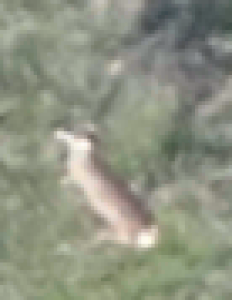

In [11]:
Image.open('/content/small_data_2/test/Ciervos/T-este_def-2-0_1553.png')

# **Normalización de imágenes, data augmentation**

In [12]:
# dimensiones a las que vamos a llevar las imágenes
img_width, img_height = 232, 300

normed_dims = (img_height, img_width)

In [13]:
train_data_dir = 'small_data_2/train'
validation_data_dir = 'small_data_2/validation'
test_data_dir = 'small_data_2/test'

batch_size = 16

In [14]:
# data augmentation:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

# **Inception v3**

In [15]:
from keras.applications.inception_v3 import decode_predictions

In [16]:
from keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False)
preprocess_input = lambda x:x/255. # una "lambda function"

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


87916544/87910968 [==============================] - 1s 0us/step


In [17]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

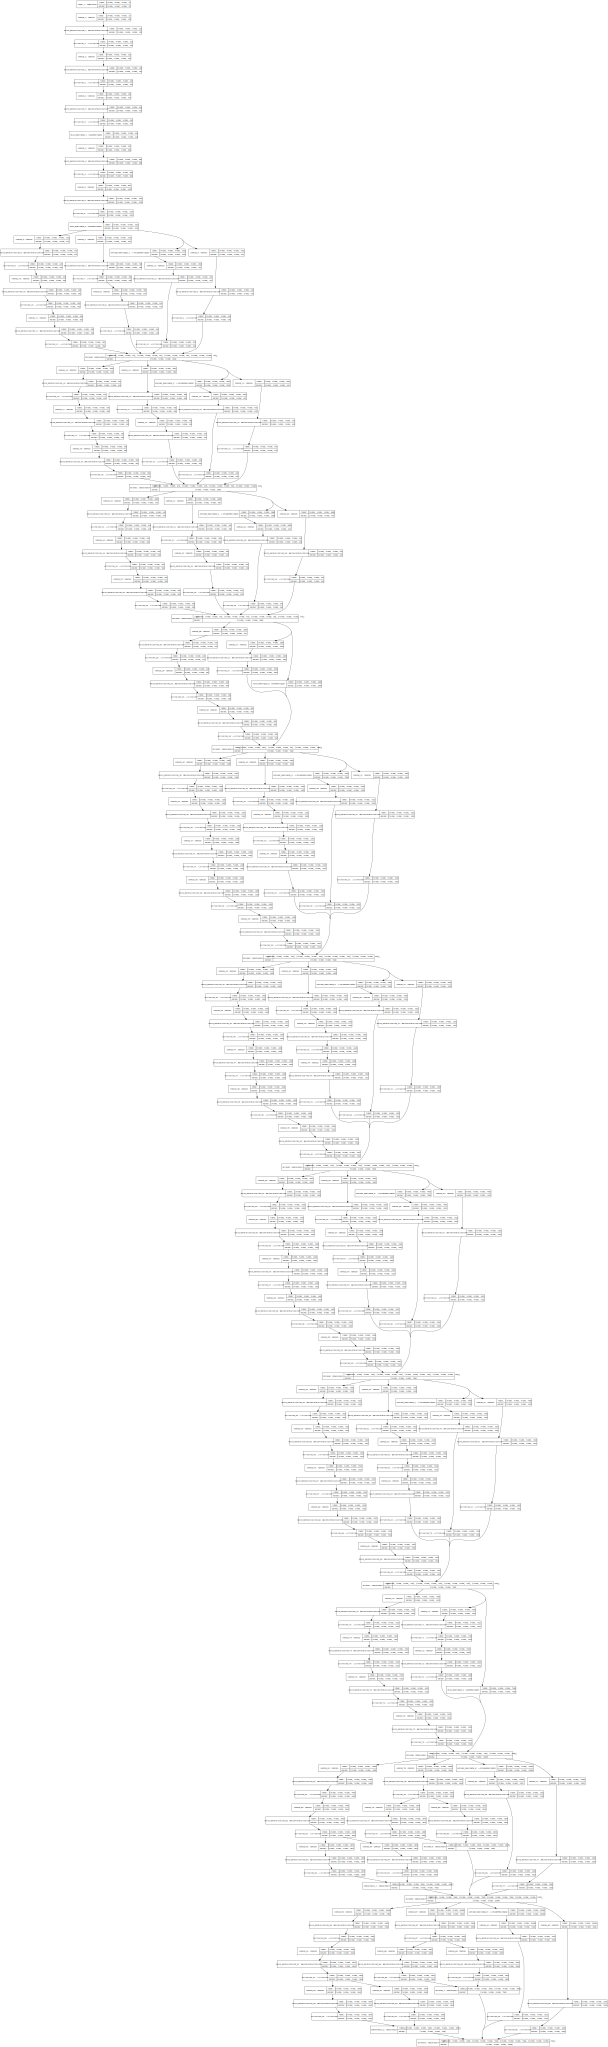

In [18]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

if COLAB:
    display(SVG(model_to_dot(base_model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(base_model, show_shapes=True).create(prog='dot', format='svg')))

In [19]:
# capas que añado:

aux = base_model.output
aux = GlobalAveragePooling2D()(aux)
#aux = Flatten(input_shape = (2048,))(aux)
aux = Dense(16, activation='relu',
            #kernel_regularizer=regularizers.l2(0.01) # 0.1, 0.01, 0.001
            )(aux)
aux = Dense(1, activation="sigmoid")(aux)
model = Model(inputs=base_model.input, outputs=aux)

model.compile(optimizer='rmsprop', loss='binary_crossentropy',
              metrics=["acc"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

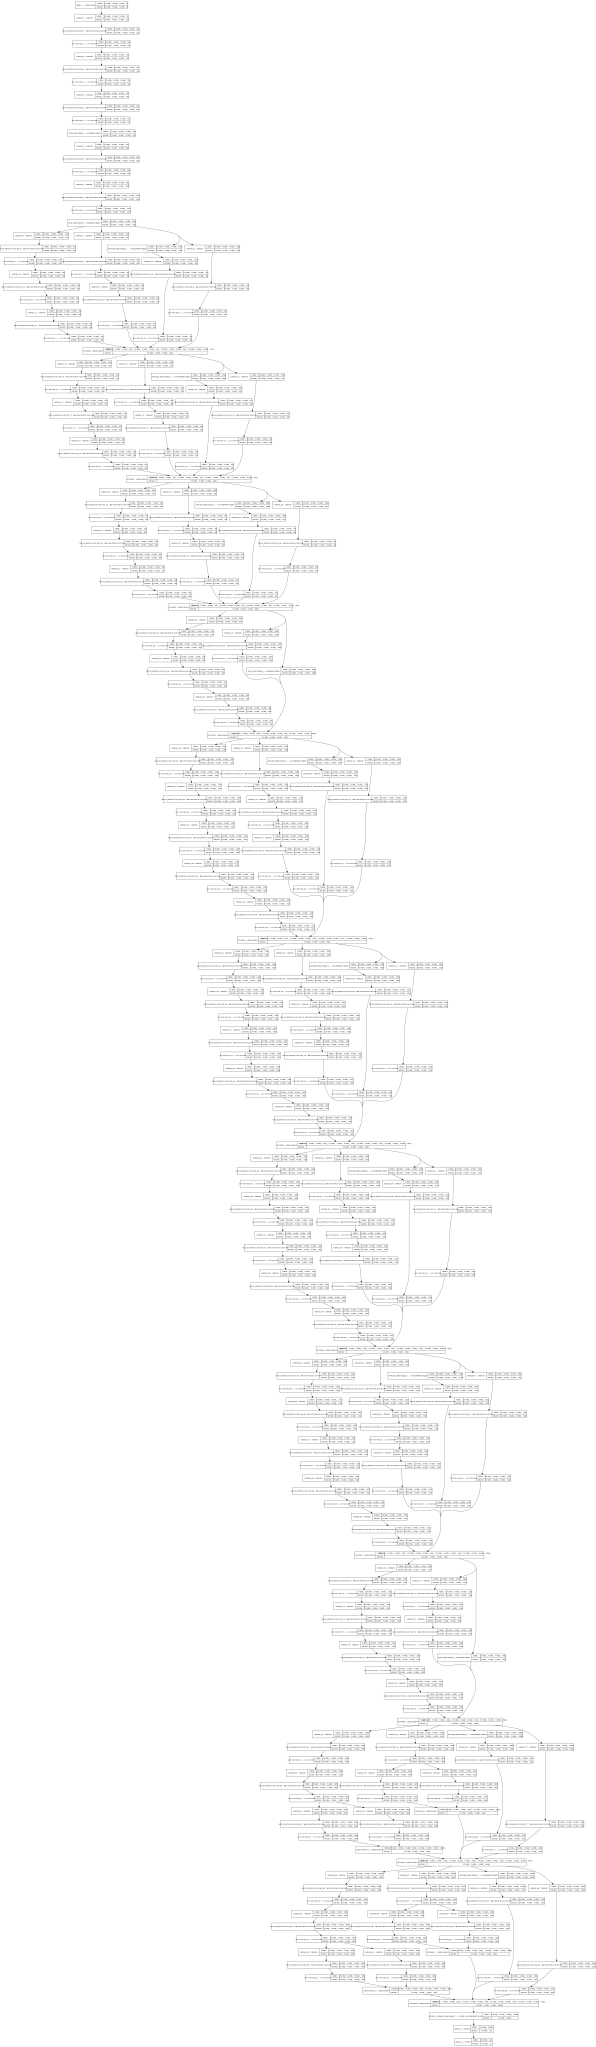

In [21]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [22]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    #rescale=1. / 255,
    preprocessing_function = preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen  = ImageDataGenerator(dtype='float32',
                                  #rescale=1. / 255,
                                  preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32',
                                  #rescale=1. / 255,
                                  preprocessing_function = preprocess_input)

In [23]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary')

Found 240 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [24]:
train_generator.class_indices

{'Ciervos': 0, 'No_Ciervos': 1}

In [25]:
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n
number_test_samples  = test_generator.n

number_train_samples, number_val_samples, number_test_samples

(240, 80, 80)

In [26]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [27]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

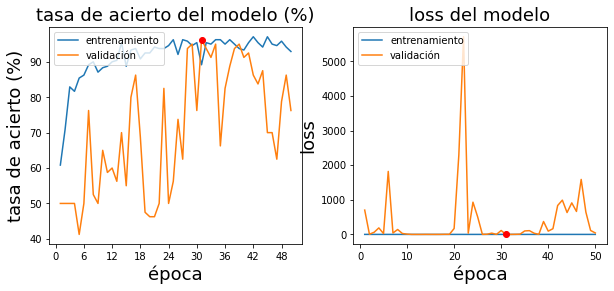

In [28]:
epochs = 50

modelpath="model_current_best_parte3.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_acc', verbose=1,
                              save_best_only=True,
                              mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    history = model.fit_generator(generator = train_generator, 
                                  steps_per_epoch=number_train_samples // batch_size,
                                  epochs=1,
                                  callbacks=callbacks_list,
                                  verbose=1,
                                  shuffle = True,
                                  validation_data=validation_generator,
                                  validation_steps=number_val_samples // batch_size
                                  )
    
    if history.history['val_acc'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_acc'])
        print("saving weights")
        best_val_acc = history.history['val_acc'][-1]
    
    acum_tr_acc.append(history.history['acc'][0])
    acum_val_acc.append(history.history['val_acc'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [29]:
model = load_model(modelpath)

In [30]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model.evaluate(test_generator)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

15/15 [==============================] - 4s 235ms/step
Train loss    : 0.22178074717521667
Train accuracy: 0.9666666388511658

5/5 [==============================] - 0s 53ms/step
Val loss    : 0.9930261373519897
Val accuracy: 0.9624999761581421

5/5 [==============================] - 0s 54ms/step
Test loss     : 0.05831827595829964
Test accuracy : 0.9624999761581421


In [31]:
y_real = test_generator.classes
y_pred_proba = model.predict_generator(test_generator)
y_pred = np.round(y_pred_proba)
print('')
print(classification_report(y_real, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.95      0.96        40
           1       0.95      0.97      0.96        40

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80



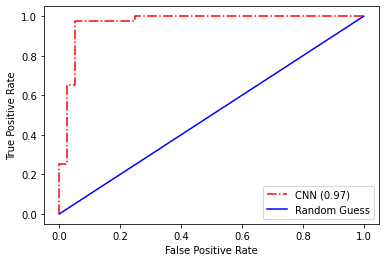

In [32]:
fpr, tpr, thresholds = roc_curve(y_real, y_pred_proba)
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()
plt.show()

## **Visualización de ejemplos de test**

In [33]:
test_datagen2 = ImageDataGenerator(dtype='float32')

test_generator2 = test_datagen2.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=test_generator.n,
    shuffle=False,
    class_mode='binary')

Found 80 images belonging to 2 classes.


In [34]:
test_generator2.reset()
X_te, y_te = test_generator2.next()

In [35]:
test_generator2.class_indices

{'Ciervos': 0, 'No_Ciervos': 1}

Probabilidad No Ciervo: 9.6e+01%


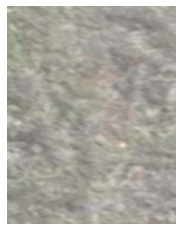

In [36]:
ind_te1 = 50

image = X_te[ind_te1].copy()

plt.imshow(image/255, cmap='jet')
plt.axis("off")
p = model.predict(preprocess_input(np.array([image])))[0,0]
print("Probabilidad No Ciervo: {:2.2}%".format(100*p))